In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [3]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [4]:
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data') 

In [5]:
labels = os.listdir(data_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_data = []
labels_data = []
for label in labels:
    for filename in os.listdir(data_dir + '/' + label ):
        files_data.append(data_dir + '/' + label + '/' + filename)
        labels_data.append(label)

In [6]:
labels

['Non_violation', 'Violation']

In [7]:
print("The first five files from the list of train images:", files_data[:5])
print("\nThe first five labels from the list of train labels:", labels_data[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_2_2994144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/Copy of _6_5523581.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_0_5482144.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_4_27430.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data/Non_violation/_11_1737337.jpg']

The first five labels from the list of train labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']


In [8]:
print(len(labels_data))

1289


In [9]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

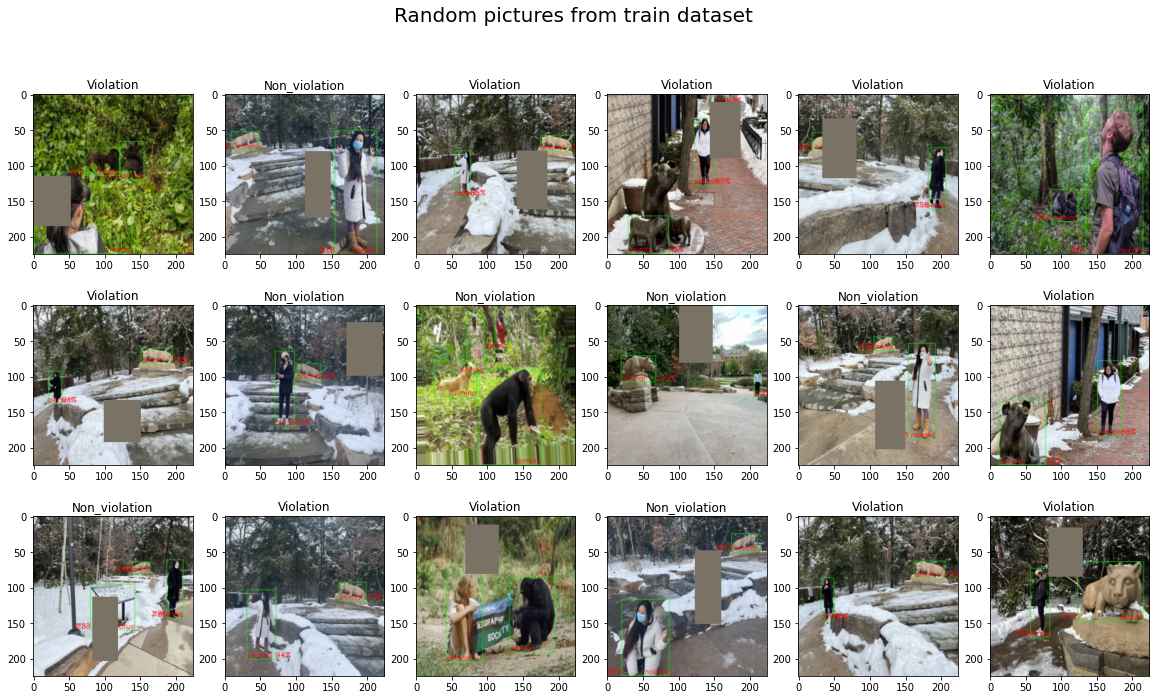

In [10]:

dataset = ImagesDataset(files=files_data,
                              labels=labels_data,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')



fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(dataset))
    img = dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([dataset[n][1]])[0])
    ax.imshow(img)

In [11]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [900, 289, 100])

In [12]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

900 289 100


In [13]:
labels_test = []
for i in range(len(test_dataset)):
  labels_test.append(encoder_labels.inverse_transform([test_dataset[i][1]])[0])

In [14]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [24]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
num_epochs = 35

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [01:37<55:18, 97.59s/it]

	| New lowest val loss for DenseNet161: 0.007747515778228073
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [02:08<31:58, 58.13s/it]

	| New lowest val loss for DenseNet161: 0.005958649835784542
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [02:38<24:15, 45.49s/it]

	| New lowest val loss for DenseNet161: 0.005313030576210946
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [03:08<20:21, 39.42s/it]

	| New lowest val loss for DenseNet161: 0.005199560760214254
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:38<18:03, 36.12s/it]

	| New lowest val loss for DenseNet161: 0.0046364957898545845
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [04:09<16:28, 34.08s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:38<15:15, 32.71s/it]

	| New lowest val loss for DenseNet161: 0.0044370774682417876
Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [05:09<14:22, 31.96s/it]

	| New lowest val loss for DenseNet161: 0.004375460805777448
Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [05:39<13:34, 31.31s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [06:09<12:53, 30.93s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [06:39<12:14, 30.59s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [07:08<11:38, 30.39s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [07:38<11:05, 30.25s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [08:09<10:36, 30.32s/it]

	| New lowest val loss for DenseNet161: 0.004294423444460832
Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [08:39<10:05, 30.26s/it]

	| New lowest val loss for DenseNet161: 0.004063232547271623
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [09:09<09:31, 30.10s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [09:39<08:59, 30.00s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [10:08<08:28, 29.93s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [10:38<07:58, 29.88s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [11:08<07:27, 29.86s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [11:38<06:58, 29.90s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [12:08<06:28, 29.91s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [12:37<05:57, 29.81s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [13:07<05:27, 29.78s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [13:37<04:58, 29.80s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [14:06<04:27, 29.73s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [14:36<03:58, 29.76s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [15:06<03:28, 29.79s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [15:36<02:58, 29.81s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [16:06<02:29, 29.82s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [16:36<01:59, 29.82s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [17:05<01:29, 29.78s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [17:35<00:59, 29.75s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [18:05<00:29, 29.78s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [18:35<00:00, 31.86s/it]


Training complete in 18m 35s


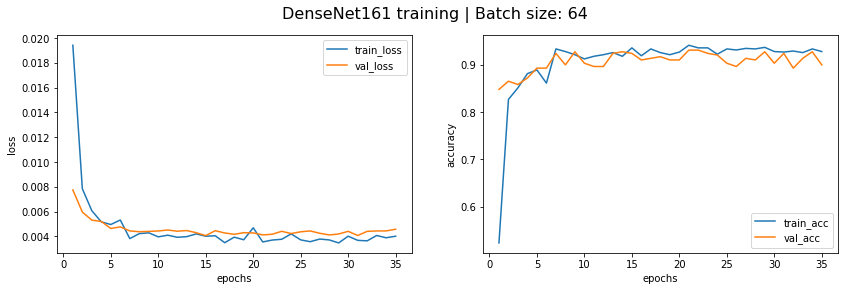


Training results:
	Min val loss 0.0041 was achieved during epoch #15
	Val accuracy during min val loss is 0.9239


In [18]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:28<15:58, 28.18s/it]

	| New lowest val loss for ResNet50: 0.018268493013810946
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [00:56<15:27, 28.11s/it]

	| New lowest val loss for ResNet50: 0.008220051708518427
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [01:24<15:01, 28.16s/it]

	| New lowest val loss for ResNet50: 0.005620668297407949
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [01:52<14:28, 28.01s/it]

Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [02:20<13:59, 27.99s/it]

Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [02:48<13:32, 28.01s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [03:16<13:05, 28.04s/it]

	| New lowest val loss for ResNet50: 0.005335143590055947
Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [03:44<12:35, 27.97s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [04:11<12:05, 27.91s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [04:39<11:37, 27.88s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [05:08<11:12, 28.02s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [05:35<10:42, 27.94s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [06:04<10:16, 28.01s/it]

	| New lowest val loss for ResNet50: 0.005266811505320988
Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [06:32<09:48, 28.01s/it]

	| New lowest val loss for ResNet50: 0.005227447999802428
Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [07:00<09:20, 28.04s/it]

	| New lowest val loss for ResNet50: 0.005167609680070184
Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [07:27<08:51, 27.97s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [07:56<08:24, 28.01s/it]

	| New lowest val loss for ResNet50: 0.005105501794897561
Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [08:24<07:55, 28.00s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [08:51<07:26, 27.91s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [09:19<06:58, 27.90s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [09:47<06:30, 27.89s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [10:15<06:02, 27.87s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [10:43<05:34, 27.89s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [11:11<05:07, 27.96s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [11:39<04:40, 28.02s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [12:07<04:12, 28.07s/it]

	| New lowest val loss for ResNet50: 0.004890519648687237
Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [12:35<03:44, 28.03s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [13:03<03:15, 27.96s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [13:31<02:47, 27.94s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [13:59<02:19, 27.91s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [14:26<01:51, 27.88s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [14:54<01:23, 27.91s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [15:22<00:55, 27.87s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [15:50<00:27, 27.90s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [16:18<00:00, 27.97s/it]


Training complete in 16m 19s


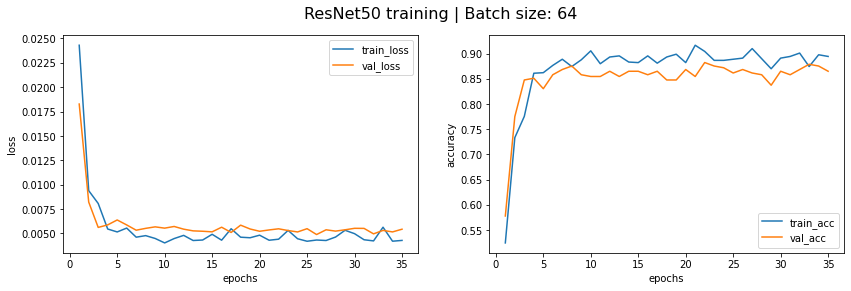


Training results:
	Min val loss 0.0049 was achieved during epoch #26
	Val accuracy during min val loss is 0.8685


In [19]:
model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)

resnet50_training_results = training(model=model_resnet50,
                                      model_name='ResNet50',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet50, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet50_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet50",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:37<21:21, 37.68s/it]

	| New lowest val loss for ResNet152: 0.01825081580237946
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:13<20:07, 36.60s/it]

	| New lowest val loss for ResNet152: 0.008458094819606795
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [01:49<19:17, 36.19s/it]

	| New lowest val loss for ResNet152: 0.008336081533696
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:24<18:36, 36.02s/it]

	| New lowest val loss for ResNet152: 0.0077999408476080445
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [03:00<17:54, 35.80s/it]

	| New lowest val loss for ResNet152: 0.006737921786555782
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [03:36<17:16, 35.75s/it]

	| New lowest val loss for ResNet152: 0.006396344273148111
Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [04:09<16:15, 34.85s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [04:39<15:04, 33.49s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [05:10<14:12, 32.77s/it]

	| New lowest val loss for ResNet152: 0.006100800932484927
Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [05:42<13:27, 32.30s/it]

	| New lowest val loss for ResNet152: 0.005781782024046954
Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [06:12<12:42, 31.75s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [06:43<12:02, 31.43s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [07:13<11:26, 31.22s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [07:46<11:05, 31.68s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [08:21<10:52, 32.62s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [08:56<10:33, 33.32s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [09:31<10:07, 33.76s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [10:06<09:40, 34.12s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [10:41<09:10, 34.40s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [11:16<08:38, 34.58s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [11:51<08:05, 34.70s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [12:26<07:32, 34.81s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [13:01<06:58, 34.87s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [13:36<06:23, 34.89s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [14:11<05:49, 34.96s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [14:47<05:16, 35.21s/it]

	| New lowest val loss for ResNet152: 0.00558779334526986
Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [15:22<04:40, 35.12s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [15:57<04:06, 35.17s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [16:32<03:30, 35.15s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [17:07<02:55, 35.14s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [17:42<02:20, 35.08s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [18:17<01:45, 35.03s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [18:50<01:08, 34.44s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [19:21<00:33, 33.36s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [19:52<00:00, 34.06s/it]


Training complete in 19m 52s


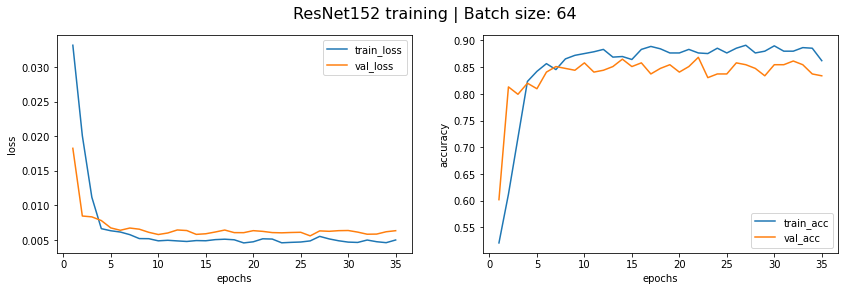


Training results:
	Min val loss 0.0056 was achieved during epoch #26
	Val accuracy during min val loss is 0.8581


In [23]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:31<17:40, 31.19s/it]

	| New lowest val loss for VGG16: 0.006910134300228634
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:02<17:11, 31.25s/it]

	| New lowest val loss for VGG16: 0.005760327703400054
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [01:33<16:37, 31.17s/it]

	| New lowest val loss for VGG16: 0.005541556331113136
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:02<15:40, 30.34s/it]

Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [02:34<15:23, 30.77s/it]

	| New lowest val loss for VGG16: 0.0034031098431369427
Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [03:03<14:34, 30.14s/it]

Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [03:31<13:52, 29.73s/it]

Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [04:00<13:14, 29.44s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [04:29<12:42, 29.33s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [04:58<12:09, 29.19s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [05:27<11:37, 29.06s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [05:56<11:07, 29.01s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [06:25<10:37, 28.96s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [06:53<10:06, 28.86s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [07:22<09:36, 28.83s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [07:51<09:07, 28.81s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [08:22<08:49, 29.44s/it]

	| New lowest val loss for VGG16: 0.0032050298417315762
Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [08:51<08:17, 29.24s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [09:19<07:44, 29.03s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [09:48<07:14, 28.94s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [10:17<06:44, 28.89s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [10:45<06:14, 28.81s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [11:14<05:45, 28.79s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [11:45<05:23, 29.43s/it]

	| New lowest val loss for VGG16: 0.0031185972804016722
Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [12:14<04:52, 29.25s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [12:42<04:21, 29.05s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [13:11<03:51, 28.91s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [13:40<03:21, 28.83s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [14:08<02:52, 28.80s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [14:39<02:26, 29.38s/it]

	| New lowest val loss for VGG16: 0.0028293747648235838
Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [15:08<01:56, 29.15s/it]

Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [15:36<01:26, 28.99s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [16:05<00:57, 28.87s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [16:34<00:28, 28.81s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [17:02<00:00, 29.22s/it]


Training complete in 17m 3s


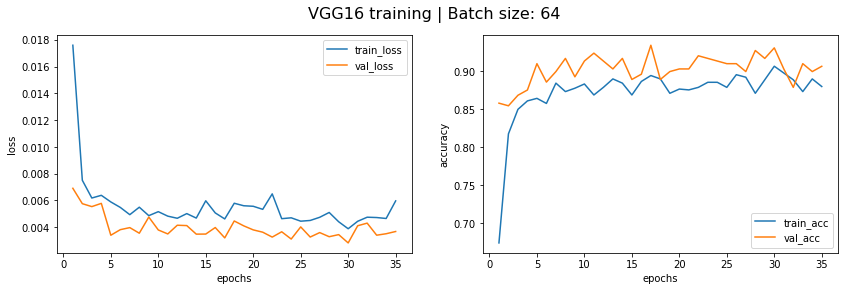


Training results:
	Min val loss 0.0028 was achieved during epoch #30
	Val accuracy during min val loss is 0.9308


In [20]:
model_vgg16 = models.vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)

vgg16_training_results = training(model=model_vgg16,
                                     model_name='VGG16',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg16, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg16_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG16",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  3%|▎         | 1/35 [00:31<18:02, 31.85s/it]

	| New lowest val loss for VGG19_bn: 0.011918071850773372
Epoch: 2 | Learning rate: [0.007]


  6%|▌         | 2/35 [01:03<17:34, 31.96s/it]

	| New lowest val loss for VGG19_bn: 0.007731041590647714
Epoch: 3 | Learning rate: [0.007]


  9%|▊         | 3/35 [01:35<17:00, 31.89s/it]

	| New lowest val loss for VGG19_bn: 0.007014727406848261
Epoch: 4 | Learning rate: [0.00231]


 11%|█▏        | 4/35 [02:07<16:30, 31.95s/it]

	| New lowest val loss for VGG19_bn: 0.006456295717958761
Epoch: 5 | Learning rate: [0.00231]


 14%|█▍        | 5/35 [02:37<15:34, 31.16s/it]

Epoch: 6 | Learning rate: [0.00231]


 17%|█▋        | 6/35 [03:09<15:10, 31.39s/it]

	| New lowest val loss for VGG19_bn: 0.006089861417724187
Epoch: 7 | Learning rate: [0.0007623]


 20%|██        | 7/35 [03:41<14:45, 31.62s/it]

	| New lowest val loss for VGG19_bn: 0.005970414586133198
Epoch: 8 | Learning rate: [0.0007623]


 23%|██▎       | 8/35 [04:11<13:57, 31.02s/it]

Epoch: 9 | Learning rate: [0.0007623]


 26%|██▌       | 9/35 [04:43<13:34, 31.32s/it]

	| New lowest val loss for VGG19_bn: 0.005310014251194198
Epoch: 10 | Learning rate: [0.00025155900000000005]


 29%|██▊       | 10/35 [05:13<12:52, 30.91s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 31%|███▏      | 11/35 [05:45<12:30, 31.26s/it]

	| New lowest val loss for VGG19_bn: 0.005205737368870772
Epoch: 12 | Learning rate: [0.00025155900000000005]


 34%|███▍      | 12/35 [06:17<12:04, 31.50s/it]

	| New lowest val loss for VGG19_bn: 0.0047866573176994455
Epoch: 13 | Learning rate: [8.301447000000002e-05]


 37%|███▋      | 13/35 [06:47<11:21, 30.99s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 40%|████      | 14/35 [07:17<10:48, 30.86s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 43%|████▎     | 15/35 [07:49<10:25, 31.30s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 46%|████▌     | 16/35 [08:21<09:56, 31.37s/it]

Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 49%|████▊     | 17/35 [08:52<09:25, 31.40s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 51%|█████▏    | 18/35 [09:24<08:54, 31.43s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 54%|█████▍    | 19/35 [09:54<08:17, 31.12s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 57%|█████▋    | 20/35 [10:27<07:53, 31.59s/it]

	| New lowest val loss for VGG19_bn: 0.0046704041813484115
Epoch: 21 | Learning rate: [9.040275783000003e-06]


 60%|██████    | 21/35 [10:57<07:17, 31.23s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 63%|██████▎   | 22/35 [11:30<06:51, 31.65s/it]

	| New lowest val loss for VGG19_bn: 0.004610810106600857
Epoch: 23 | Learning rate: [2.983291008390001e-06]


 66%|██████▌   | 23/35 [12:00<06:15, 31.27s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 69%|██████▊   | 24/35 [12:33<05:49, 31.77s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


 71%|███████▏  | 25/35 [13:08<05:26, 32.61s/it]

Epoch: 26 | Learning rate: [9.844860327687004e-07]


 74%|███████▍  | 26/35 [13:43<04:58, 33.20s/it]

Epoch: 27 | Learning rate: [9.844860327687004e-07]


 77%|███████▋  | 27/35 [14:17<04:28, 33.59s/it]

Epoch: 28 | Learning rate: [3.2488039081367115e-07]


 80%|████████  | 28/35 [14:51<03:56, 33.82s/it]

Epoch: 29 | Learning rate: [3.2488039081367115e-07]


 83%|████████▎ | 29/35 [15:26<03:23, 33.97s/it]

Epoch: 30 | Learning rate: [3.2488039081367115e-07]


 86%|████████▌ | 30/35 [16:00<02:50, 34.07s/it]

Epoch: 31 | Learning rate: [1.0721052896851149e-07]


 89%|████████▊ | 31/35 [16:37<02:20, 35.01s/it]

	| New lowest val loss for VGG19_bn: 0.00434595578475807
Epoch: 32 | Learning rate: [1.0721052896851149e-07]


 91%|█████████▏| 32/35 [17:12<01:44, 34.87s/it]

Epoch: 33 | Learning rate: [1.0721052896851149e-07]


 94%|█████████▍| 33/35 [17:46<01:09, 34.78s/it]

Epoch: 34 | Learning rate: [3.5379474559608795e-08]


 97%|█████████▋| 34/35 [18:21<00:34, 34.67s/it]

Epoch: 35 | Learning rate: [3.5379474559608795e-08]


100%|██████████| 35/35 [18:55<00:00, 32.45s/it]


Training complete in 18m 56s


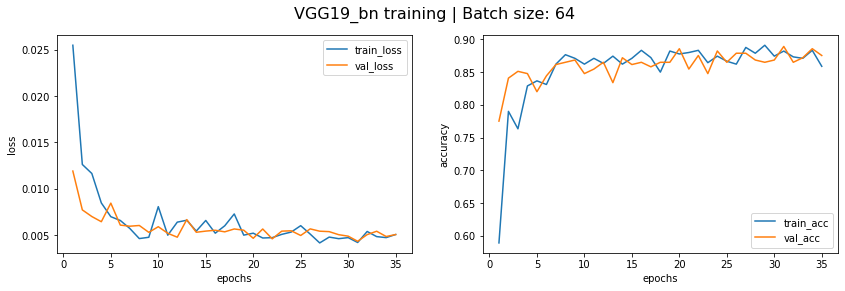


Training results:
	Min val loss 0.0043 was achieved during epoch #31
	Val accuracy during min val loss is 0.8893


In [21]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [22]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE

        #remove last linear layer
        # self.modelA.fc = nn.Identity()
        # self.modelB.fc = nn.Identity()
        # self.modelC.fc = nn.Identity()
        # self.modelD.fc = nn.Identity()
        # self.modelE.fc = nn.Identity()

        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

NameError: ignored

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.007]


  4%|▍         | 1/25 [01:09<27:51, 69.64s/it]

	| New lowest val loss for Ensemble: 0.012622730542219221
Epoch: 2 | Learning rate: [0.007]


  8%|▊         | 2/25 [02:19<26:50, 70.04s/it]

	| New lowest val loss for Ensemble: 0.011187747726700299
Epoch: 3 | Learning rate: [0.007]


 12%|█▏        | 3/25 [03:23<24:39, 67.27s/it]

Epoch: 4 | Learning rate: [0.00231]


 16%|█▌        | 4/25 [04:33<23:55, 68.34s/it]

	| New lowest val loss for Ensemble: 0.010062919484909017
Epoch: 5 | Learning rate: [0.00231]


 20%|██        | 5/25 [05:38<22:17, 66.86s/it]

Epoch: 6 | Learning rate: [0.00231]


 24%|██▍       | 6/25 [06:48<21:30, 67.91s/it]

	| New lowest val loss for Ensemble: 0.005331622520429452
Epoch: 7 | Learning rate: [0.0007623]


 28%|██▊       | 7/25 [07:52<19:58, 66.61s/it]

Epoch: 8 | Learning rate: [0.0007623]


 32%|███▏      | 8/25 [08:55<18:36, 65.69s/it]

Epoch: 9 | Learning rate: [0.0007623]


 36%|███▌      | 9/25 [09:59<17:21, 65.10s/it]

Epoch: 10 | Learning rate: [0.00025155900000000005]


 40%|████      | 10/25 [11:03<16:11, 64.74s/it]

Epoch: 11 | Learning rate: [0.00025155900000000005]


 44%|████▍     | 11/25 [12:07<15:02, 64.49s/it]

Epoch: 12 | Learning rate: [0.00025155900000000005]


 48%|████▊     | 12/25 [13:11<13:56, 64.32s/it]

Epoch: 13 | Learning rate: [8.301447000000002e-05]


 52%|█████▏    | 13/25 [14:15<12:50, 64.19s/it]

Epoch: 14 | Learning rate: [8.301447000000002e-05]


 56%|█████▌    | 14/25 [15:19<11:45, 64.14s/it]

Epoch: 15 | Learning rate: [8.301447000000002e-05]


 60%|██████    | 15/25 [16:23<10:40, 64.09s/it]

Epoch: 16 | Learning rate: [2.7394775100000007e-05]


 64%|██████▍   | 16/25 [17:33<09:53, 65.97s/it]

	| New lowest val loss for Ensemble: 0.004485160163942093
Epoch: 17 | Learning rate: [2.7394775100000007e-05]


 68%|██████▊   | 17/25 [18:37<08:43, 65.44s/it]

Epoch: 18 | Learning rate: [2.7394775100000007e-05]


 72%|███████▏  | 18/25 [19:41<07:34, 64.98s/it]

Epoch: 19 | Learning rate: [9.040275783000003e-06]


 76%|███████▌  | 19/25 [20:45<06:28, 64.67s/it]

Epoch: 20 | Learning rate: [9.040275783000003e-06]


 80%|████████  | 20/25 [21:49<05:22, 64.44s/it]

Epoch: 21 | Learning rate: [9.040275783000003e-06]


 84%|████████▍ | 21/25 [22:53<04:17, 64.30s/it]

Epoch: 22 | Learning rate: [2.983291008390001e-06]


 88%|████████▊ | 22/25 [23:57<03:12, 64.16s/it]

Epoch: 23 | Learning rate: [2.983291008390001e-06]


 92%|█████████▏| 23/25 [25:01<02:08, 64.07s/it]

Epoch: 24 | Learning rate: [2.983291008390001e-06]


 96%|█████████▌| 24/25 [26:05<01:04, 64.01s/it]

Epoch: 25 | Learning rate: [9.844860327687004e-07]


100%|██████████| 25/25 [27:09<00:00, 65.17s/it]


Training complete in 27m 9s


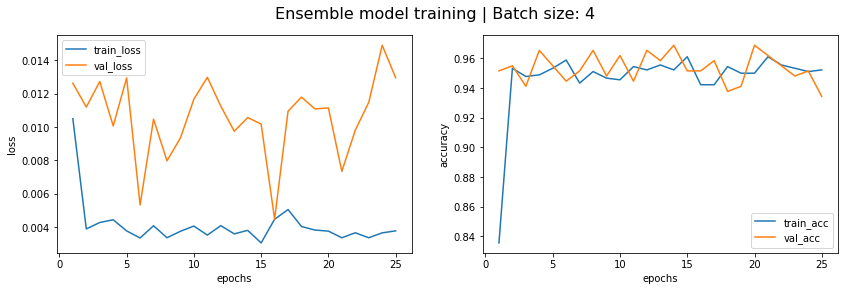


Training results:
	Min val loss 0.0045 was achieved during iteration #16
	Val accuracy during min val loss is 0.9516


In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=35,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=35,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_preds_decoded = encoder_labels.inverse_transform(all_preds)


100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


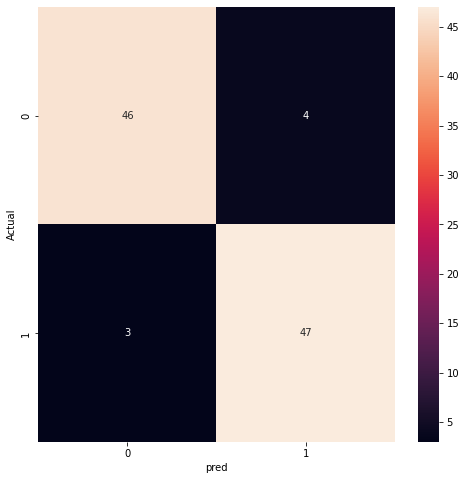

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.94      0.92      0.93        50
    Violation       0.92      0.94      0.93        50

     accuracy                           0.93       100
    macro avg       0.93      0.93      0.93       100
 weighted avg       0.93      0.93      0.93       100



In [ ]:
# print("Our model: \n\n", ensemble_model, '\n')
# print("The state dict keys: \n\n", ensemble_model.state_dict().keys())

In [ ]:
model_save_name = 'ensembleclassifier5.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(ensemble_model.state_dict(), path)

In [ ]:
model_save_name = 'ensembleclassifier5.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
ensemble_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# ensemble_model.eval()

In [ ]:
# import matplotlib.pyplot as plt

# import torch
# from torch import nn
# from torch import optim
# import torch.nn.functional as F
# from torchvision import datasets, transforms

# # upload external file before import
# from google.colab import files
# files.upload()
# import helper

# files.upload()
# import fc_model

In [ ]:
torch.save(ensemble_model.state_dict(), 'checkpoint_ensemble5.pth')

# download checkpoint file
# ensemble_model.download('checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint_ensemble5.pth')
# print(state_dict.keys())

In [ ]:
ensemble_model.load_state_dict(state_dict)

<All keys matched successfully>

test on other data

In [ ]:
test2_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing')
test3_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation') 

In [ ]:
test4_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/other_animals')
test5_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/human_human')

In [ ]:
# List of files for testing
files_test2 = []
labels_test2 = []
for label in labels:
  for filename in os.listdir(test2_dir + '/' + label):
      files_test2.append(test2_dir + '/' + label + '/' + filename)
      files_test2 = sorted(files_test2)
      labels_test2.append(label)

files_test3 = []
labels_test3 = []
for label in labels:
  for filename in os.listdir(test3_dir + '/' + label):
      files_test3.append(test3_dir + '/' + label + '/' + filename)
      files_test3 = sorted(files_test3)
      labels_test3.append(label)
files_test4 = []
labels_test4 = []
for label in labels:
  for filename in os.listdir(test4_dir + '/' + label):
      files_test4.append(test4_dir + '/' + label + '/' + filename)
      files_test4 = sorted(files_test4)
      labels_test4.append(label)

files_test5 = []
labels_test5 = []
for label in labels:
  for filename in os.listdir(test5_dir + '/' + label):
      files_test5.append(test5_dir + '/' + label + '/' + filename)
      files_test5 = sorted(files_test5)
      labels_test5.append(label)

In [ ]:
print("\nThe first five files from the list of test images:", files_test2[:5])
print("\nThe first five labels from the list of test labels:", labels_test2[:5])
print("\nThe first five files from the list of test images:", files_test3[:5])
print("\nThe first five labels from the list of test labels:", labels_test3[:5])
print("\nThe first five files from the list of test images:", files_test4[:5])
print("\nThe first five labels from the list of test labels:", labels_test4[:5])
print("\nThe first five files from the list of test images:", files_test5[:5])
print("\nThe first five labels from the list of test labels:", labels_test5[:5])


The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2532090.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_2857314.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_4326839.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _0_6340112.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing/Non_violation/Copy of _2_1274240.jpg']

The first five labels from the list of test labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']

The first five files from the list of test images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Benchmark_validation/Non_violation/IMG_1736.JPG', '/content/gdrive/MyDrive/GTVD

In [ ]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [ ]:
test_dataset2 = ImagesDataset(files=files_test2,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset3 = ImagesDataset(files=files_test3,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset4 = ImagesDataset(files=files_test4,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')
test_dataset5 = ImagesDataset(files=files_test5,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

In [ ]:
print(len(test_dataset2),len(test_dataset3), len(test_dataset4),len(test_dataset5))

48 142 78 16


In [ ]:
test_dataloader2 = DataLoader(test_dataset2, batch_size=8, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=20, shuffle=False)
test_dataloader4 = DataLoader(test_dataset4, batch_size=16, shuffle=False)
test_dataloader5 = DataLoader(test_dataset5, batch_size=4, shuffle=False)

In [ ]:
all_preds2 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader2):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds2.extend(preds.tolist())

all_preds_decoded2 = encoder_labels.inverse_transform(all_preds2)


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


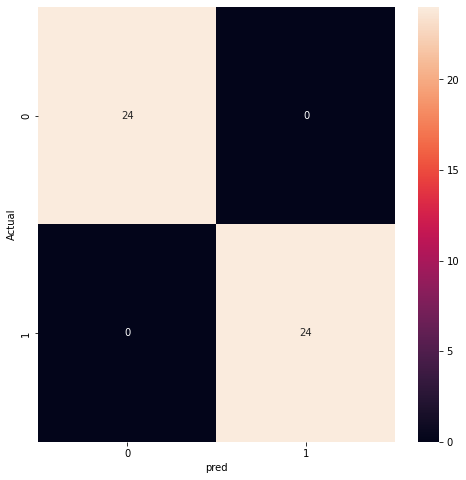

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test2, all_preds_decoded2)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test2, all_preds_decoded2,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       1.00      1.00      1.00        24
    Violation       1.00      1.00      1.00        24

     accuracy                           1.00        48
    macro avg       1.00      1.00      1.00        48
 weighted avg       1.00      1.00      1.00        48



In [ ]:
all_preds3 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader3):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds3.extend(preds.tolist())

all_preds_decoded3 = encoder_labels.inverse_transform(all_preds3)

100%|██████████| 8/8 [00:37<00:00,  4.74s/it]


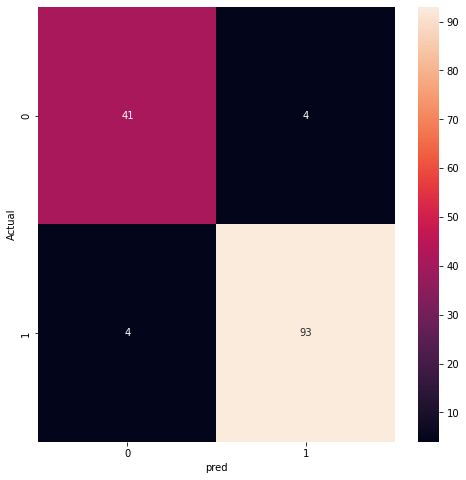

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test3, all_preds_decoded3)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test3, all_preds_decoded3,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.91      0.91      0.91        45
    Violation       0.96      0.96      0.96        97

     accuracy                           0.94       142
    macro avg       0.93      0.93      0.93       142
 weighted avg       0.94      0.94      0.94       142



In [ ]:
all_preds4 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader4):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds4.extend(preds.tolist())

all_preds_decoded4 = encoder_labels.inverse_transform(all_preds4)

100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


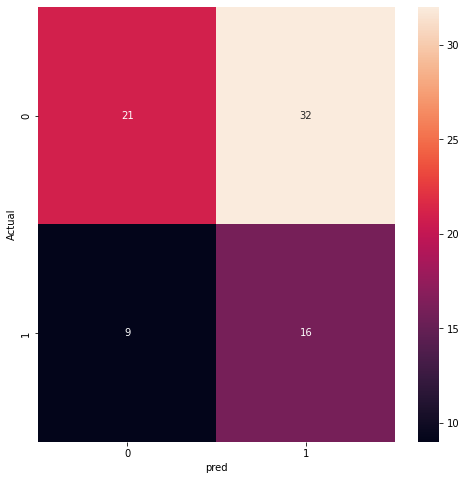

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test4, all_preds_decoded4)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
matrix = classification_report(labels_test4, all_preds_decoded4,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.70      0.40      0.51        53
    Violation       0.33      0.64      0.44        25

     accuracy                           0.47        78
    macro avg       0.52      0.52      0.47        78
 weighted avg       0.58      0.47      0.48        78



In [ ]:
all_preds5 = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader5):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds5.extend(preds.tolist())

all_preds_decoded5 = encoder_labels.inverse_transform(all_preds5)

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


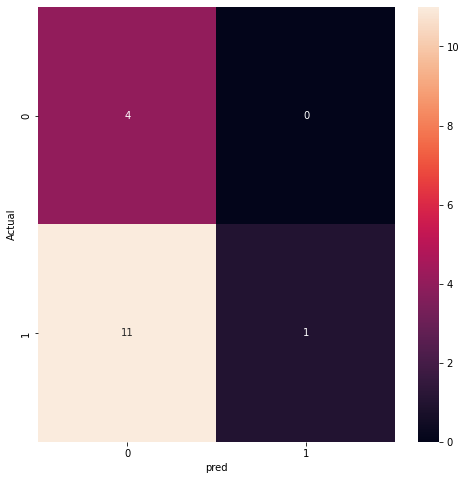

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test5, all_preds_decoded5)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [ ]:
matrix = classification_report(labels_test5, all_preds_decoded5,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       0.27      1.00      0.42         4
    Violation       1.00      0.08      0.15        12

     accuracy                           0.31        16
    macro avg       0.63      0.54      0.29        16
 weighted avg       0.82      0.31      0.22        16



In [ ]:
!ls 

checkpoint_ensemble4.pth  gdrive		 sample_data
DenseNet161_weights.pth   ResNet152_weights.pth  VGG16_weights.pth
Ensemble_weights.pth	  ResNet50_weights.pth	 VGG19_bn_weights.pth


In [ ]:
!jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/ensemble_MixedData_v2

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v2.ipynb to html
[NbConvertApp] Writing 2420398 bytes to /content/gdrive/MyDrive/Colab Notebooks/ensemble_MixedData_v2.html
